In [112]:
import numpy as np
import h5py
import tensorflow as tf
import keras
from keras.models import Sequential, Model
from keras.layers import Conv1D, MaxPooling1D
from keras.layers import Input, Embedding
from keras.layers import Dense, Merge, Dropout
from keras.layers import LSTM, Bidirectional
from keras import metrics
import keras.backend as K

In [155]:
#with tf.device('/device:GPU:0'):
alphabet = "NACGT"
vocab_size = len(alphabet)
time_steps = 100
embedding_size = 300 # for embedding layer, maybe remove
dense_size = 300
category = 10 # size of Y_vector

#dimension_factors = [0.68385941, 0.07137607, 0.07067572, 0.042682, 0.03364847, 0.0262762, 0.0227149, 0.02118112, 0.01409905, 0.01348706]
#dimension_factors = [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1]
dimension_factors = [0.5, 0.055, 0.055, 0.055, 0.055, 0.055, 0.055, 0.055, 0.055, 0.055]
#dimension_factors = [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
def weighted_square_error(y_true, y_pred):
    #return K.mean(K.square(y_pred - y_true)*dimension_factors, axis=-1) #quickly goes to <=0.1 for 0.1 factors
    return K.sum(K.square(y_pred - y_true)*dimension_factors, axis=-1)

model = Sequential()
#model.add(Embedding(vocab_size, embedding_size, batch_input_shape=(batch_size, time_steps)))
model.add(Embedding(vocab_size, embedding_size, input_length=time_steps))

model.add(Bidirectional(LSTM(units=300, return_sequences=True)))
#model.add(Dropout(0.250))
model.add(Bidirectional(LSTM(units=300)))
#model.add(Dropout(0.250))

model.add(Dense(dense_size, activation='relu'))
model.add(Dense(dense_size, activation='relu'))
model.add(Dense(category, activation='linear'))

#model.compile(optimizer='adam', loss=weighted_square_error, metrics=[weighted_square_error])
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_squared_error']) - quickly goes to <= 1.1

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_27 (Embedding)     (None, 100, 300)          1500      
_________________________________________________________________
bidirectional_53 (Bidirectio (None, 100, 600)          1442400   
_________________________________________________________________
bidirectional_54 (Bidirectio (None, 600)               2162400   
_________________________________________________________________
dense_80 (Dense)             (None, 300)               180300    
_________________________________________________________________
dense_81 (Dense)             (None, 300)               90300     
_________________________________________________________________
dense_82 (Dense)             (None, 10)                3010      
Total params: 3,879,910
Trainable params: 3,879,910
Non-trainable params: 0
_________________________________________________________________


In [142]:
# testing the custom keras function
dimension_factors = [0.68385941, 0.07137607, 0.07067572, 0.042682, 0.03364847, 0.0262762, 0.0227149, 0.02118112, 0.01409905, 0.01348706]
#dimension_factors = [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
def weighted_square_error(y_true, y_pred):
    return K.sum(K.square(y_pred - y_true)*dimension_factors, axis=-1)
res = weighted_square_error(np.array([5.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]), np.array([0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0]))
print(K.eval(res))

17.41262584


In [106]:
h5f = h5py.File('X_train_superfam_16S_bacteria_and_archaea.h5','r')
X_train = h5f['X'][:]
h5f.close()
h5f = h5py.File('Y_train_superfam_16S_bacteria_and_archaea.h5','r')
Y_train = h5f['Y'][:]
h5f.close()
print(X_train.shape)
print(Y_train.shape)

(97900, 100)
(97900, 10)


In [167]:
#random_index = np.random.permutation(Y_train.shape[0])
#Y_train_fake = Y_train[random_index, :]

batch_size = 128
history = model.fit(X_train, Y_train,
                    validation_split=0.2, 
                    batch_size=batch_size, shuffle=True, epochs=50)

Train on 78320 samples, validate on 19580 samples
Epoch 1/50
78320/78320 [==============================] - 882s - loss: 0.0982 - mean_squared_error: 0.0982 - val_loss: 0.2961 - val_mean_squared_error: 0.2961
Epoch 2/50
78320/78320 [==============================] - 768s - loss: 0.1343 - mean_squared_error: 0.1343 - val_loss: 0.3195 - val_mean_squared_error: 0.3195
Epoch 3/50
78320/78320 [==============================] - 777s - loss: 0.1409 - mean_squared_error: 0.1409 - val_loss: 0.3590 - val_mean_squared_error: 0.3590
Epoch 4/50
78320/78320 [==============================] - 880s - loss: 0.1057 - mean_squared_error: 0.1057 - val_loss: 0.3342 - val_mean_squared_error: 0.3342
Epoch 5/50
78320/78320 [==============================] - 787s - loss: 0.1176 - mean_squared_error: 0.1176 - val_loss: 0.3124 - val_mean_squared_error: 0.3124
Epoch 6/50
78320/78320 [==============================] - 846s - loss: 0.1029 - mean_squared_error: 0.1029 - val_loss: 0.2863 - val_mean_squared_error: 0.2

In [166]:
from keras.models import load_model
import copy
import pickle

#history_epoch_1_30_16S = copy.deepcopy(history.history)
#history_epoch_30_45_16S = copy.deepcopy(history.history)

#history.history['mean_squared_error'] = history_epoch_1_30_16S['mean_squared_error'] + history.history['mean_squared_error']
#history.history['val_mean_squared_error'] = history_epoch_1_30_16S['val_mean_squared_error'] + history.history['val_mean_squared_error']

#with open('Dec8_16S_model_history.txt', 'wb') as handle:
#    pickle.dump(history.history, handle)

#model.save('Dec8_16S_model.h5')

#del model 
model = load_model('Dec5_16S_model.h5')

In [73]:
model.predict(X_train[:1])

array([[-0.19722965, -1.1290468 ,  0.00663682,  0.5998646 , -0.52686131,
         1.06232429, -0.3202346 ,  0.28701526, -0.20310611,  0.05939835]], dtype=float32)

In [78]:
print(Y_train[:1])

[[ 0.27738296 -1.29981422 -0.10408728  0.20743367 -0.5760618   1.0140479
  -0.33179031  0.15838494 -0.25340111 -0.0586683 ]]


hi
loaded


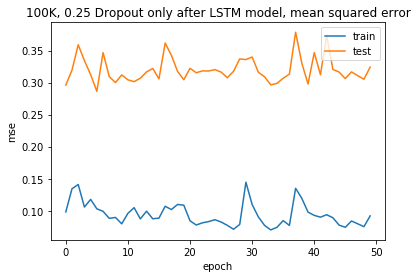

In [168]:
%matplotlib inline
import matplotlib.pyplot as plt
print("hi")
#plt.plot(history_epoch_1_50_100K['mean_squared_error'] + history_epoch_50_100_100K['mean_squared_error'])
#plt.plot(history_epoch_1_50_100K['val_mean_squared_error'] + history_epoch_50_100_100K['val_mean_squared_error'])
with open('Dec5_16S_model_history.txt', 'rb') as handle:
    dec5_45_epochs_history = pickle.loads(handle.read())
print("loaded")
plt.plot(history.history['mean_squared_error'])
plt.plot(history.history['val_mean_squared_error'])
plt.title('100K, 0.25 Dropout only after LSTM model, mean squared error')
plt.ylabel('mse')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')

In [82]:
print(saved_history['val_mean_squared_error'])

[1.1152145929336548, 1.1127177652359008, 1.115556632900238, 1.0984653748512268, 1.0980269250869752, 1.0839108215332032, 1.0810902829170228, 1.0668039016723634, 1.063988427734375, 1.0626038724899292, 1.0565018127441406, 1.0604716356277466, 1.0592864610671997, 1.0640272480010986, 1.08308115234375, 1.0825496788024902, 1.0731799563407898, 1.0853037510871888, 1.0913260318756104, 1.0955821699142456, 1.1005252833366395, 1.1017409677505494, 1.0921395937919616, 1.1131556457519531, 1.1242903165817262, 1.1159117254257203, 1.1210998012542726, 1.140155369567871, 1.130773374080658, 1.1409612243652343, 1.1394356515884398, 1.1660277717590333, 1.1569550365447998, 1.152776338005066, 1.1483390762329102, 1.1804546925544739, 1.1667144771575928, 1.1805262058258057, 1.1889802804946898, 1.1689506666183471, 1.1838653376579285, 1.1901697471618653, 1.1791342103958129, 1.1826737288475038, 1.1886965372085572, 1.195158969116211, 1.1991167499542237, 1.1929523714065551, 1.2051368055343628, 1.193604618358612]


In [102]:
# EVALUATION STARTS HERE
h5f = h5py.File('X_test_superfam_16S_bacteria_and_archaea.h5','r')
X_test = h5f['X'][:]
h5f.close()

In [103]:
predictions = model.predict(X_test)
#print(predictions)

In [104]:
h5f_Y = h5py.File('test_evaluation_Dec6_model_superfam_16S_bacteria_and_archaea.h5', 'w')
h5f_Y.create_dataset('Y', data=predictions)
h5f_Y.close()

In [79]:
X_test[:1]

array([[1, 4, 2, 1, 4, 4, 4, 3, 1, 3, 4, 1, 4, 4, 3, 1, 1, 4, 4, 3, 4, 4,
        4, 3, 3, 1, 4, 4, 3, 2, 2, 2, 3, 3, 3, 4, 4, 3, 3, 2, 1, 4, 2, 3,
        3, 2, 3, 2, 2, 2, 3, 1, 3, 3, 2, 3, 4, 2, 3, 4, 3, 2, 2, 2, 3, 3,
        2, 3, 2, 2, 4, 2, 3, 1, 1, 4, 3, 3, 2, 1, 3, 2, 2, 4, 2, 3, 3, 2,
        2, 4, 3, 4, 2, 2, 3, 1, 1, 3, 2, 3]])

In [80]:
model.predict(X_test[:1])

array([[ 0.23048048, -0.78514469, -0.07407849,  0.18304779, -0.05353191,
        -0.46164179, -0.0345975 , -0.1873433 ,  0.647035  , -0.16296008]], dtype=float32)